# USADS509 M2 UE Wang

# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here

import glob
import regex as re
#import fasttext
import sqlite3
import html
import textacy
import textacy.preprocessing as tprep
import nltk
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex


In [3]:
# change `data_location` to the location of the folder on your machine.

data_location = "/Users/UE/Desktop/M1 Results"
# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))  
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(s) for s in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")        
        print (f"The five most common words are:")
        print(Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The five most common words are:
[('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: <!-- Your answer here --> 

Using assertion statements can help ensure that the code is running as expected. They allow users to spot issues before actually running the dataset, acting as a form of pre-execution checks.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data

lyrics_data = {}

lyrics_path = os.path.join(data_location, lyrics_folder)

for artist_folder in os.listdir(lyrics_path):
    artist_folder_path = os.path.join(lyrics_path, artist_folder)

    if os.path.isdir(artist_folder_path):
        # Use glob to find all text files in the artist folder
        file_paths = glob.glob(os.path.join(artist_folder_path, '*.txt'))

        # Read the contents of each text file and store in artist_lyrics
        artist_lyrics = [open(file_path, 'r').read() for file_path in file_paths]

        lyrics_data[artist_folder] = artist_lyrics
        
print("Sample for robynkonichiwa:", lyrics_data['robyn'][:1])
print("--------------------------------------------")
print("Sample for cher:", lyrics_data['cher'][:1])

Sample for robynkonichiwa: ['"Include Me Out"\n\n\n\nIt is really very simple\nJust a single pulse, repeated at a regular interval\n\nMmm, hmm\nDon\'t include me out, no\nDon\'t include me out\n\nOne time for the records and the hits\nTwo for your money-maker, shake, boom\nThree times for the lucky and the dead\n\nOne time for the sorry and safe\nTwo for the beggar and his company\nThree times for the sinner and the saint\n\nYeah, bow down all you wicked and the vain\nBow to the miracle, the em, na, na\nThree times and the devil will be gone\n\nOne time for the fire, bring it on\nTwo for the boogie, gotta bang the beat\nThree times for the ladies, show me some love\n\nTalking \'bout everyone, every day, all day\n\nAnd if your world should fall apart\nThere\'s plenty room inside my heart\nJust don\'t include me out\nDon\'t include me out\n\nAnd if your world should fall apart\nI still got room inside my heart\nJust don\'t include me out\nDon\'t include me out, d-d-don\'t include me out\

In [7]:
import os

twitter_files = os.path.join(data_location, twitter_folder)
desc_files = [f for f in os.listdir(twitter_files) if "followers_data" in f]

twitter_data = {}

for f in desc_files:
    artist = f.split("_")[0]
    
    if artist == 'robynkonichiwa' or artist == 'cher':
        if artist not in twitter_data:
            twitter_data[artist] = []  # Initialize the list for the artist if it doesn't exist
        
        with open(os.path.join(data_location, twitter_folder, f), 'r', encoding='utf8') as infile:
            next(infile)
            for idx, line in enumerate(infile.readlines()):
                line = line.strip().split("\t") 
                if len(line) == 7:  
                    twitter_data[artist].append(line[6])
                    
print("Sample for robynkonichiwa:", twitter_data['robynkonichiwa'][:5])
print("-------------------------------------------")
print("Sample for cher:", twitter_data['cher'][:5])

Sample for robynkonichiwa: ['"I love chill" •Facebook / Instagram / SoundCloud: AngelxoArts• https://t.co/447okKLKzA…', "books, movies, music, nature & TV shows. OG Sweetee since '12 thanks to YouTube recommending 'This Feeling' on my homepage ♥️", '(Am)auteur en herbe 🌱 - juriste en paille 🤡 - Ami des fleurs 🌸🌈 (sans la main verte) - music & books - #morecomingsoon... (si on en voit le bout)', 'This Twitter profile is full of sarcasm and rants with the occasional moan, dont like me dont follow me! KLF Stan Account Aspiring Youth Council rep', 'Flora Youssef - Blogger & Founder Posting review articles about the latest music 🎵 https://t.co/dx4hoIom7T https://t.co/KsplT6mZzs']
-------------------------------------------
Sample for cher: ['𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜', '163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡', 'csu', 'Writer @Washinformer @SpelmanCollege alumna #DCnative Award-winning journalist & PR pro @IABC Fellow & Past Chair IG: bcscomm Email: wibsiler@gmail.com', 'I’

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [8]:
punctuation = set(punctuation) # speeds up comparison
stopwords = set(nltk.corpus.stopwords.words('english'))

In [9]:
# create your clean twitter data here
clean_twitter = {}

for artist_name, twitter_descriptions in twitter_data.items():
    clean_twitter_descriptions = []

    for twitter_description in twitter_descriptions:
        # Remove punctuation
        twitter_description = ''.join([ch for ch in twitter_description if ch not in punctuation])

        # Split on whitespace and fold to lowercase
        tokens_twitter = twitter_description.lower().split()

        # Remove stopwords
        tokens_twitter = [token for token in tokens_twitter if token not in sw]

        clean_twitter_descriptions.append(tokens_twitter)

    clean_twitter[artist_name] = clean_twitter_descriptions

In [10]:
#convert to dataframe, and name the original tweet as tweet

print("robyn tweet")

robyn_tweet = pd.DataFrame(twitter_data['robynkonichiwa'])
robyn_tweet.columns = ['tweet']
display(robyn_tweet.head())

print("cher tweet")

cher_tweet = pd.DataFrame(twitter_data['cher'])
cher_tweet.columns = ['tweet']
display(cher_tweet.head())

robyn tweet


,tweet
0,"""I love chill"" •Facebook / Instagram / SoundCl..."
1,"books, movies, music, nature & TV shows. OG Sw..."
2,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,This Twitter profile is full of sarcasm and ra...
4,Flora Youssef - Blogger & Founder Posting revi...


cher tweet


,tweet
0,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
1,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
2,csu
3,Writer @Washinformer @SpelmanCollege alumna #D...
4,I’m unemployed and live with my parents. MOOPS!


In [11]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

def tokenize(text):
    # Remove punctuation characters, split on whitespace, and fold to lowercase
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

def prepare_text(row):
    original_text = row['tweet']
    
    # Apply the pipeline to the 'tweet' column
    tokens = original_text
    for transform in pipeline:
        tokens = transform(tokens)
    
    return pd.Series({'tweet': original_text, 'tokens': tokens})

pipeline = [tokenize, remove_stop]

In [12]:
#add the tokens column to the original dataframe

print("robyn tweet")

robyn_tweet[['tweet', 'tokens']] = robyn_tweet.apply(prepare_text, axis=1)
display(robyn_tweet.head())

print("cher tweet")
cher_tweet[['tweet', 'tokens']] = cher_tweet.apply(prepare_text, axis=1)
display(cher_tweet.head())

robyn tweet


,tweet,tokens
0,"""I love chill"" •Facebook / Instagram / SoundCl...","[love, chill, facebook, instagram, soundcloud,..."
1,"books, movies, music, nature & TV shows. OG Sw...","[books, movies, music, nature, tv, shows, og, ..."
2,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...,"[auteur, en, herbe, juriste, en, paille, ami, ..."
3,This Twitter profile is full of sarcasm and ra...,"[twitter, profile, full, sarcasm, rants, occas..."
4,Flora Youssef - Blogger & Founder Posting revi...,"[flora, youssef, blogger, founder, posting, re..."


cher tweet


,tweet,tokens
0,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]"
1,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,"[163, 愛かっぷ, 26歳, 工〇好きな女の子, フォローしてくれたらdmします]"
2,csu,[csu]
3,Writer @Washinformer @SpelmanCollege alumna #D...,"[writer, washinformer, spelmancollege, alumna,..."
4,I’m unemployed and live with my parents. MOOPS!,"[unemployed, live, parents, moops]"


In [13]:
# create your clean lyrics data here

print("robyn lyrics")

robyn_lyrics = pd.DataFrame(lyrics_data['robyn'])
robyn_lyrics.columns = ['lyrics']
display(robyn_lyrics.head())

print("cher lyrics")

cher_lyrics = pd.DataFrame(lyrics_data['cher'])
cher_lyrics.columns = ['lyrics']
display(cher_lyrics.head())

robyn lyrics


,lyrics
0,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


cher lyrics


,lyrics
0,"""Come And Stay With Me""\n\n\n\nI'll send away ..."
1,"""Pirate""\n\n\n\nHe'll sail on with the summer ..."
2,"""Stars""\n\n\n\nI was never one for saying what..."
3,"""These Days""\n\n\n\nWell I've been out walking..."
4,"""Love So High""\n\n\n\nEvery morning I would wa..."


In [14]:
def prepare_text2(row):
    original_text = row['lyrics']
    
    # Apply the pipeline to the 'tweet' column
    tokens = original_text
    for transform in pipeline:
        tokens = transform(tokens)
    
    return pd.Series({'lyrics': original_text, 'tokens': tokens})

#add the tokens column to the original dataframe

print("robyn lyrics")

robyn_lyrics[['lyrics', 'tokens']] = robyn_lyrics.apply(prepare_text2, axis=1)
display(robyn_lyrics.head())

print("cher lyrics")
cher_lyrics[['lyrics', 'tokens']] = cher_lyrics.apply(prepare_text2, axis=1)
display(cher_lyrics.head())

robyn lyrics


,lyrics,tokens
0,"""Include Me Out""\n\n\n\nIt is really very simp...","[include, really, simple, single, pulse, repea..."
1,"""Electric""\n\n\n\nElectric...\n\nIt's electric...","[electric, electric, electric, natural, high, ..."
2,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...","[beach, 2k20, wanna, go, gonna, get, ok, call,..."
3,"""Love Kills""\n\n\n\nIf you're looking for love...","[love, kills, looking, love, get, heart, made,..."
4,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...","[time, machine, hey, believe, fit, threw, stup..."


cher lyrics


,lyrics,tokens
0,"""Come And Stay With Me""\n\n\n\nI'll send away ...","[come, stay, send, away, false, pride, forsake..."
1,"""Pirate""\n\n\n\nHe'll sail on with the summer ...","[pirate, sail, summer, wind, blows, day, every..."
2,"""Stars""\n\n\n\nI was never one for saying what...","[stars, never, one, saying, really, feel, exce..."
3,"""These Days""\n\n\n\nWell I've been out walking...","[days, well, walking, much, talking, days, day..."
4,"""Love So High""\n\n\n\nEvery morning I would wa...","[love, high, every, morning, would, wake, tie,..."


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [15]:
# calls to descriptive_stats here

print("robyn tweets Stats\n")

descriptive_stats(
    [token for tokens in robyn_tweet['tokens'] for token in tokens])

print("\ncher tweets Stats\n")

descriptive_stats(
    [token for tokens in cher_tweet['tokens'] for token in tokens])

print("\n robyn lyrics Stats")

descriptive_stats(
    [token for tokens in robyn_lyrics['tokens'] for token in tokens])

print("\ncher lyrics Stats")

descriptive_stats(
    [token for tokens in cher_lyrics['tokens'] for token in tokens])

robyn tweets Stats

There are 1526444 tokens in the data.
There are 205132 unique tokens in the data.
There are 8847337 characters in the data.
The lexical diversity is 0.134 in the data.
The five most common words are:
[('music', 16230), ('co', 13578), ('love', 12218), ('️', 9964), ('https', 8071)]

cher tweets Stats

There are 15788215 tokens in the data.
There are 960410 unique tokens in the data.
There are 89397530 characters in the data.
The lexical diversity is 0.061 in the data.
The five most common words are:
[('love', 225018), ('️', 134391), ('life', 133418), ('music', 97060), ('co', 75488)]

 robyn lyrics Stats
There are 13934 tokens in the data.
There are 2107 unique tokens in the data.
There are 68023 characters in the data.
The lexical diversity is 0.151 in the data.
The five most common words are:
[('know', 308), ('love', 276), ('got', 252), ('like', 232), ('baby', 222)]

cher lyrics Stats
There are 32980 tokens in the data.
There are 3555 unique tokens in the data.
There

[32980, 3555, 0.10779260157671317, 159843]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: 
Without removing stopwords, the top 5 words might include common and non-meaningful words such as "I," "Me," "you," "myself," and "and." These words, known as stopwords, are frequently used in the English language but often don't contribute significant meaning to the analysis.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: 
Higher lexical diversity score would indicate a greater variety of unique words, reflecting a more diverse vocabulary. Surprisingly, the analysis revealed that Robyn has a higher score than Cher, which might differ from common expectations. This demonstrates the value of text analysis, leveraging data to provide more accurate and insightful results.


## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [16]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [17]:
# Your code here
import emoji
from collections import Counter

def extract_emojis(text):
    return [c for c in text if emoji.is_emoji(c)]

emoji_counts = {}

for artist, tweets in twitter_data.items():
    emoji_counts[artist] = Counter()
    
    for tweet in tweets:
        emojis = extract_emojis(tweet)
        emoji_counts[artist].update(emojis)

# ten most common emojis for each artist
for artist, emojis in emoji_counts.items():
    print(f"\nArtist: {artist}\n")
    print("\nTen most common emojis:\n")
    
    for emoji, count in emojis.most_common(10):
        print(f"{emoji}: {count}")


Artist: cher


Ten most common emojis:

❤: 79223
🌈: 47549
♥: 33978
🏳: 33412
✨: 29468
💙: 21379
🏻: 20930
🌊: 20223
✌: 16773
💜: 16550

Artist: robynkonichiwa


Ten most common emojis:

❤: 4783
🌈: 4685
🏳: 3528
♥: 3103
✨: 2223
🏻: 1495
✌: 1189
🏼: 1139
♀: 836
💙: 809


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [18]:
# Your code here

import re
from collections import Counter

def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

hashtag_counts = {}

for artist, tweets in twitter_data.items():
    hashtag_counts[artist] = Counter()

    for tweet in tweets:
        hashtags = extract_hashtags(tweet)
        hashtag_counts[artist].update(hashtags)

# Print the ten most common hashtags for each artist
for artist, hashtags in hashtag_counts.items():
    print(f"\nArtist: {artist}\n")
    print("\nTen most common hashtags:\n")

    for hashtag, count in hashtags.most_common(10):
        print(f"#{hashtag}: {count}")


Artist: cher


Ten most common hashtags:

#BLM: 9535
#Resist: 6036
#BlackLivesMatter: 4681
#resist: 3797
#FBR: 3239
#TheResistance: 2995
#blacklivesmatter: 2645
#1: 2627
#Resistance: 1919
#RESIST: 1823

Artist: robynkonichiwa


Ten most common hashtags:

#BlackLivesMatter: 337
#BLM: 306
#blacklivesmatter: 208
#1: 199
#music: 174
#Music: 113
#EDM: 86
#LGBTQ: 75
#TeamFollowBack: 59
#blm: 56


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [19]:
import emoji
from collections import Counter
import re  

def extract_title(text):
    return re.findall(r'"(.*)"', text)[0].split()

title_counts = {}

for artist, lyrics in lyrics_data.items():
    title_counts[artist] = Counter()
    
    for lyric in lyrics:
        title = extract_title(lyric)
        title_counts[artist].update(title)

# ten most common song titles for each artist
for artist, titles in title_counts.items():
    print(f"\nArtist: {artist}\n")
    print("\nTen most common song titles :\n")
    
    for title, count in titles.most_common(5):
        print(f"{title}: {count}")


Artist: robyn


Ten most common song titles :

Me: 11
You: 8
The: 8
My: 8
Love: 6

Artist: cher


Ten most common song titles :

The: 53
You: 40
Love: 38
I: 32
To: 28


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

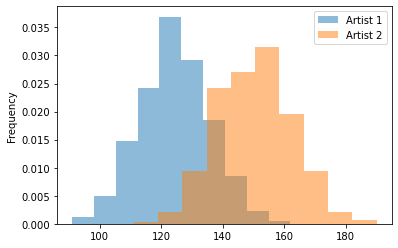

In [20]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: 
It means matches one or more whitespace characters.

In [21]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

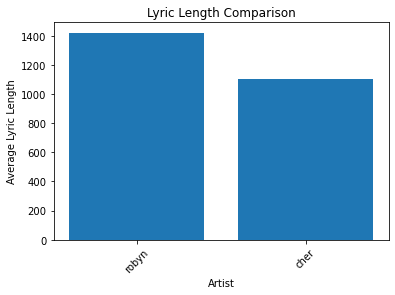

In [22]:
# Your lyric length comparison chart here. 

import matplotlib.pyplot as plt

# Dictionary to store the average lyric lengths for each artist
average_lengths = {}

# Calculate the average lyric length for each artist
for artist, lyrics_list in lyrics_data.items():
    total_length = 0
    num_lyrics = len(lyrics_list)
    for lyrics in lyrics_list:
        total_length += len(lyrics)
    average_length = total_length / num_lyrics
    average_lengths[artist] = average_length

# Convert the dictionary to lists for plotting
artists = list(average_lengths.keys())
lengths = list(average_lengths.values())

# Plot the bar chart
plt.bar(artists, lengths)
plt.xlabel('Artist')
plt.ylabel('Average Lyric Length')
plt.title('Lyric Length Comparison')
plt.xticks(rotation=45)  # Specify the rotation angle for better readability
plt.show()
